
===== SUMMARY =====
Total trials: 144
Completed trials: 144
Best FID overall: 4.3956

===== PER DATABASE BEST =====

DB: sqlite:///fid_optimization_1.db
  Best trial: 29
  Best FID: 4.4173
  a: None
  b: None
  constraint: None

DB: sqlite:///fid_optimization_2.db
  Best trial: 26
  Best FID: 4.3956
  a: None
  b: None
  constraint: None

DB: sqlite:///fid_optimization.db
  Best trial: 55
  Best FID: 4.4007
  a: 1.2301447284240619
  b: -4.0853689331499385
  constraint: -0.39493474787775235


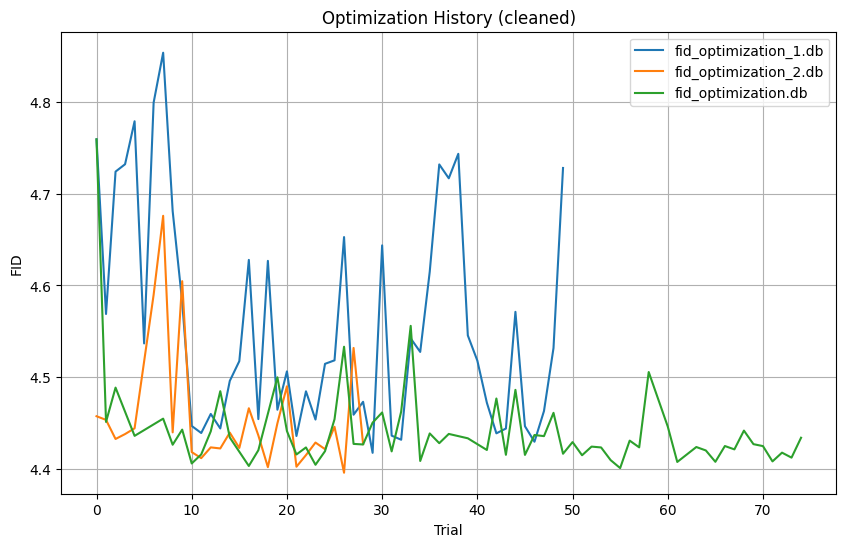

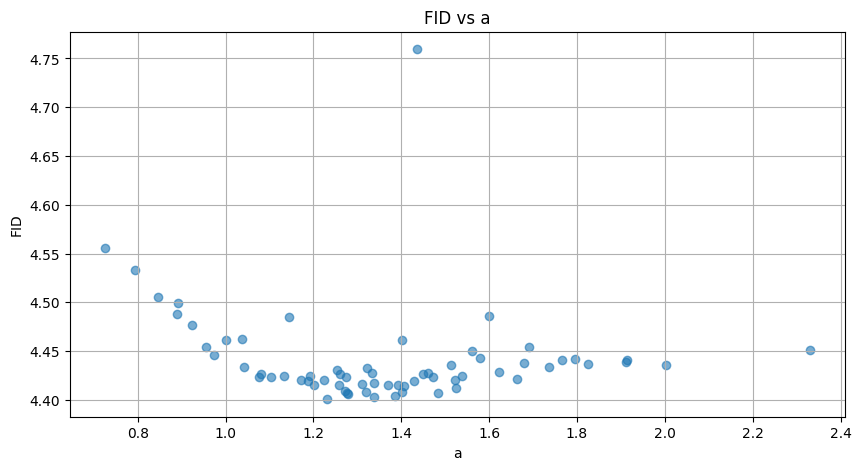

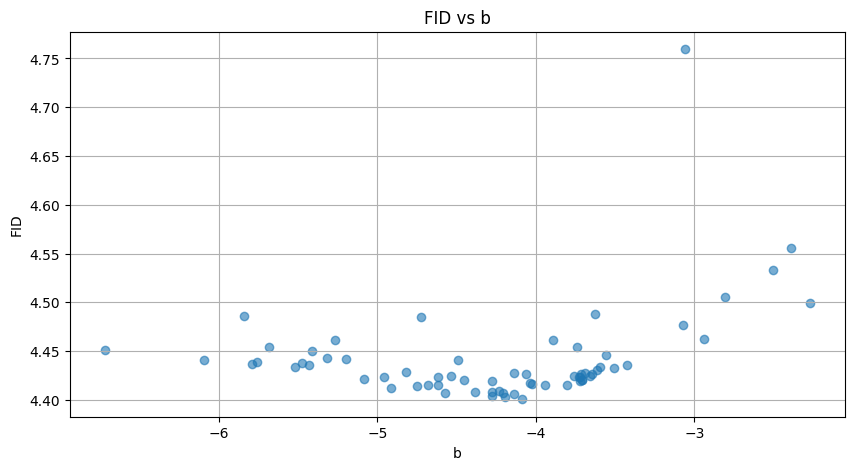


===== Parameter importance: sqlite:///fid_optimization_1.db =====

===== Parameter importance: sqlite:///fid_optimization_2.db =====
a: 1.0000

===== Parameter importance: sqlite:///fid_optimization.db =====
constraint: 0.6519
a: 0.3481

Merged CSV saved as merged_trials.csv
Plots saved in current directory.


In [3]:
import optuna
import pandas as pd
import matplotlib.pyplot as plt
import os

DBS = [
    "sqlite:///fid_optimization_1.db",
    "sqlite:///fid_optimization_2.db",
    "sqlite:///fid_optimization.db",
]

STUDY_NAME = "diffusion_fid_optimization"

def load_study_dataframe(db_path):
    study = optuna.load_study(study_name=STUDY_NAME, storage=db_path)
    df = study.trials_dataframe(attrs=("number", "value", "state", "params", "user_attrs"))
    df["source_db"] = os.path.basename(db_path)
    return study, df


all_dfs = []
studies = []

for db in DBS:
    study, df = load_study_dataframe(db)
    studies.append(study)
    all_dfs.append(df)

merged_df = pd.concat(all_dfs, ignore_index=True)
merged_df = merged_df[merged_df["value"] < 999].copy()


# Save merged CSV
# merged_df.to_csv("merged_trials.csv", index=False)

print("\n===== SUMMARY =====")
print(f"Total trials: {len(merged_df)}")
print(f"Completed trials: {(merged_df['state'] == 'COMPLETE').sum()}")
print(f"Best FID overall: {merged_df['value'].min():.4f}")

print("\n===== PER DATABASE BEST =====")
for db, study in zip(DBS, studies):
    best = study.best_trial
    print(f"\nDB: {db}")
    print(f"  Best trial: {best.number}")
    print(f"  Best FID: {best.value:.4f}")
    print(f"  a: {best.user_attrs.get('a')}")
    print(f"  b: {best.user_attrs.get('b')}")
    print(f"  constraint: {best.user_attrs.get('constraint_value')}")


# ---------- Plot optimization history ----------

plt.figure(figsize=(10, 6))

for df, db in zip(all_dfs, DBS):
    df_complete = df[
        (df["state"] == "COMPLETE") &
        (df["value"] < 999)
    ]
    plt.plot(df_complete["number"], df_complete["value"], label=os.path.basename(db))

plt.xlabel("Trial")
plt.ylabel("FID")
plt.title("Optimization History (cleaned)")
plt.legend()
plt.grid()
plt.savefig("optimization_history.png")
plt.show()



# ---------- Parameter scatter plots ----------

plt.figure(figsize=(10, 5))
plt.scatter(merged_df["user_attrs_a"], merged_df["value"], alpha=0.6)
plt.xlabel("a")
plt.ylabel("FID")
plt.title("FID vs a")
plt.grid()
plt.savefig("fid_vs_a.png")
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(merged_df["user_attrs_b"], merged_df["value"], alpha=0.6)
plt.xlabel("b")
plt.ylabel("FID")
plt.title("FID vs b")
plt.grid()
plt.savefig("fid_vs_b.png")
plt.show()


# ---------- Parameter importance (per study) ----------

for db, study in zip(DBS, studies):
    print(f"\n===== Parameter importance: {db} =====")
    importance = optuna.importance.get_param_importances(study)
    for k, v in importance.items():
        print(f"{k}: {v:.4f}")

print("\nMerged CSV saved as merged_trials.csv")
print("Plots saved in current directory.")


In [8]:
import optuna
import math

DBS = [
    "sqlite:///fid_optimization.db",
    "sqlite:///fid_optimization_1.db",
    "sqlite:///fid_optimization_2.db",
]

STUDY_NAME = "diffusion_fid_optimization"

targets = [
    ([0.0168169338469557, 0.0575429182802859, 0.1968960260143427, 0.6737239997353861], 9.84473411152397),
    ([0.0150565765163528, 0.0573856337276224, 0.2187157854074077, 0.8335987890877504], 9.723708410188832),
    ([0.0139210542980094, 0.0557095339234981, 0.2229394486606637, 0.8921632307563885], 9.571101753360923),
    ([0.0159631598274761, 0.0573198447019583, 0.2058216939607056, 0.7390559050730826], 9.717421789876106),
    ([0.0148802078120299, 0.0533830113237393, 0.1915125066792815, 0.6870545386088324], 9.639184201278692),
]

TOL = 1e-6

def match(w1, w2):
    return all(math.isclose(a, b, rel_tol=TOL, abs_tol=TOL) for a, b in zip(w1, w2))

print("\n a        b        cifar_fid     imagenet_fid")
print("-" * 50)

for weights_target, imagenet_fid in targets:
    found = False

    for db in DBS:
        study = optuna.load_study(study_name=STUDY_NAME, storage=db)

        for trial in study.trials:
            if trial.state.name != "COMPLETE":
                continue

            weights = trial.user_attrs.get("weights")
            if not weights:
                continue

            if match(weights, weights_target):
                a = trial.user_attrs.get("a")
                b = trial.user_attrs.get("b")
                cifar_fid = trial.value

                print(f"{a:.6f}  {b:.6f}  {cifar_fid:.6f}  {imagenet_fid:.6f}")
                found = True
                break

        if found:
            break

    if not found:
        print("NOT FOUND for weights:", weights_target)



 a        b        cifar_fid     imagenet_fid
--------------------------------------------------
1.230145  -4.085369  4.400661  9.844734
1.337979  -4.195940  4.402952  9.723708
1.386749  -4.274353  4.404274  9.571102
1.278363  -4.137472  4.405699  9.717422
1.277461  -4.207723  4.407353  9.639184
